In [1]:
import numpy as np
from numpy.lib import recfunctions as rfn
import matplotlib.pyplot as plt
from numba import njit
from tqdm.notebook import tqdm
import h5py as h5

import importlib
import GFM
from pygsl import spline
import warnings

In [2]:
from sys import platform
if platform == 'darwin':
    basepath = '/Users/abeane/Projects/nft'
else:
    pass

yieldpath = basepath + '/tables/Arepo_GFM_Tables_TNG/Yields'

In [3]:
importlib.reload(GFM)
importlib.reload(GFM.util)
param = GFM.TNGParameters()
IMF = GFM.ChabrierIMF(param)
LT = GFM.LifeTimes(yieldpath, param)

SNII = GFM.yieldSNII_AGB(yieldpath, param, IMF, SNII=True)
AGB = GFM.yieldSNII_AGB(yieldpath, param, IMF, AGB=True)
SNIa = GFM.yieldSNIa(yieldpath, param)
gfm = GFM.GFM(yieldpath, param)

In [4]:
import arepo
def construct_nft(imax, ntracer):
    ntracer = str(ntracer)
    nft = []
    dtypes = {'names': ('TracerID', 'TailID', 'HeadID', 'EjectFrac', 'GFM_EjectZ', 'GFM_EjectZ_fromMetals'), 
              'formats': ('int', 'int', 'int', 'float', 'float', 'float')}

    for i in range(1, imax+1):
        # fname = basepath+'/iso/runs/beta0/lvl5-'+ntracer+'/output/nft_' + str(i).zfill(3) + '.txt'
        fname = basepath+'/iso/runs/dev/lvl6-MCnft/output/nft_' + str(i).zfill(3) + '.txt'
        nft.append(np.loadtxt(fname, dtype=dtypes))

    nft = np.concatenate(nft)
    # nft['EjectTime'] = nft['EjectTime'] * 1e9 # convert to yr

    return nft

def construct_stars(i, ntracer, InitialMetallicity=0.0127):
    ntracer = str(ntracer)
    # sn = arepo.Snapshot(basepath + '/iso/runs/beta0/lvl5-'+ntracer+'/output', i, combineFiles=True)
    sn = arepo.Snapshot(basepath + '/iso/runs/dev/lvl6-MCnft/output', i, combineFiles=True)
    dtypes = {'names': ('ParticleIDs', 'BirthTime', 'GFM_Metallicity', 'GFM_InitialMass', 'Masses'), 
              'formats': ('int', 'float', 'float', 'float', 'float')}

    iter = zip(sn.part4.ParticleIDs, sn.part4.GFM_StellarFormationTime, sn.part4.GFM_Metallicity, 
               sn.part4.GFM_InitialMass, sn.part4.Masses)
    stars = np.array(list(iter), dtype=dtypes)
    
    # filter out wind particles
    stars = stars[stars['BirthTime'] > 0]

    # add big bang particle
    bigbang = np.array([(0, 0, InitialMetallicity, -1.0, -1.0)], dtype=dtypes)
    stars = np.hstack((bigbang, stars))

    # sort by particle ID
    stars = np.sort(stars, order=['ParticleIDs'])
    
    # add copy of GFM_Metallicity
    stars = rfn.append_fields(stars, 'NFT_Metallicity', stars['GFM_Metallicity'], dtypes='float')
    assert not np.ma.is_masked(stars['NFT_Metallicity'])
    stars = stars.filled()

    return stars

def construct_nft_stars(i, ntracer, InitialMetallicity=0.0127):
    nft = construct_nft(i, ntracer)
    stars = construct_stars(i, ntracer, InitialMetallicity=InitialMetallicity)
    # np.testing.assert_array_equal(np.unique(np.concatenate((nft['TailID'], nft['HeadID']))), stars['ParticleIDs'])

    # add an edge from the big bang particle to itself
    # bigbang = np.array([(0, 0, 0, 0.0)], dtype=nft.dtype)
    bigbang = np.array([(0, 0, 0, 0.0, 0.0127, 0.0127)], dtype=nft.dtype)
    nft = np.hstack((bigbang, nft))

    # now some additional fields
    tail_idx = np.searchsorted(stars['ParticleIDs'], nft['TailID'])
    head_idx = np.searchsorted(stars['ParticleIDs'], nft['HeadID'])
    nft = rfn.append_fields(nft, ['TailIdx', 'HeadIdx', 'TailMetallicity'], [tail_idx, head_idx, stars['NFT_Metallicity'][tail_idx]], dtypes=['int', 'int', 'float'])
    assert not np.ma.is_masked(nft['TailMetallicity'])
    nft = nft.filled()

    return nft, stars


/opt/homebrew/lib/python3.11/site-packages/gadget/simulation.py:17: UserWarning: Could not load calcGrid, plotting function will not work
  warnings.warn("Could not load calcGrid, plotting function will not work")
/opt/homebrew/lib/python3.11/site-packages/gadget/DGsimulation.py:16: UserWarning: Could not load calcGrid, plotting function will not work
  warnings.warn("Could not load calcGrid, plotting function will not work")


In [5]:
def get_NFT_Metallicity(nft, stars):
    diff = 1e99
    TailZ = stars['GFM_Metallicity'][nft['TailIdx']]

    NFT_Metallicity_iter = []
    NFT_Metallicity_iter.append(stars['GFM_Metallicity'])
    while diff > 1e-6:
        print(diff)
        OldTailZ = np.copy(TailZ)
        # EdgeZ = SED.ejected_metallicity(TailZ, nft['EjectTime'])
        EdgeZ = np.zeros_like(TailZ)

        EdgeZ = np.zeros_like(TailZ)
        EdgeZ[nft['TailID'] == 0] = 0.0127
        
        frac = nft['EjectFrac'][nft['TailID'] != 0]
        df = 0.01 * frac
        mej, met = gfm.get_total_mass_ejected_at_frac(frac-df/2., frac+df/2., TailZ[nft['TailID'] != 0])

        key_zero = np.where(mej == 0.0)[0]
        print('num zero=', len(key_zero))
        mej[key_zero] = 1.0
        met[key_zero] = 0.2

        EdgeZ[nft['TailID'] != 0] = met / mej
        # EdgeZ[nft['TailID'] != 0] = 0.2

        Head_ct = np.bincount(nft['HeadIdx'])
        Head_zsum = np.bincount(nft['HeadIdx'], weights=EdgeZ)
        stars['NFT_Metallicity'] = Head_zsum/Head_ct # note - len(stars), not len(nft)
        NFT_Metallicity_iter.append(stars['NFT_Metallicity'])
        TailZ = stars['NFT_Metallicity'][nft['TailIdx']]
        diff = np.max(np.abs(OldTailZ - TailZ))
        # diff = 0.0
    
    nft = rfn.append_fields(nft, 'EdgeZ', EdgeZ, dtypes='float')
    assert not np.ma.is_masked(nft['EdgeZ'])
    nft = nft.filled()
    
    return nft, stars, NFT_Metallicity_iter

In [6]:
gfm.get_total_mass_ejected_at_frac(0.01, 0.051, 0.0127)

(0.041000000044459015, 0.011177968298747948)

In [7]:
# Nlist = [512, 1024]
# Nlist = [512]
Nlist = [-1]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    nft, stars, NFT_Metallicity_iter = {}, {}, {}
    for N in Nlist:
        nft[N], stars[N] = construct_nft_stars(50, N)

In [58]:
for N in Nlist:
    nft[N], stars[N], NFT_Metallicity_iter[N] = get_NFT_Metallicity(nft[N], stars[N])
print(len(NFT_Metallicity_iter[N]))

1e+99


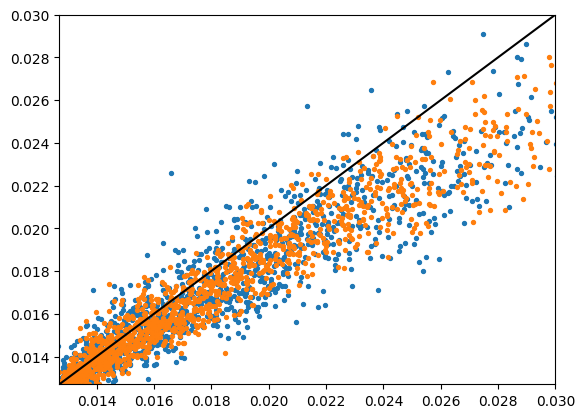

In [232]:
plt.scatter(stars[512]['GFM_Metallicity'], stars[512]['NFT_Metallicity'], s=8)
plt.scatter(stars[1024]['GFM_Metallicity'], stars[1024] ['NFT_Metallicity'], s=8)
# plt.scatter(stars[2048]['GFM_Metallicity'], stars[2048]['NFT_Metallicity'], s=8)
# plt.scatter(stars[512]['GFM_Metallicity'], NFT_Metallicity_iter[512][1], s=8)
# plt.scatter(stars[512]['GFM_Metallicity'], NFT_Metallicity_iter[1], s=8)
# plt.scatter(stars[512]['GFM_Metallicity'], NFT_Metallicity_iter[2], s=8)
plt.xlim(0.0127, 0.03)
plt.ylim(0.0127, 0.03)
plt.plot([0, 0.06], [0, 0.06], c='k')

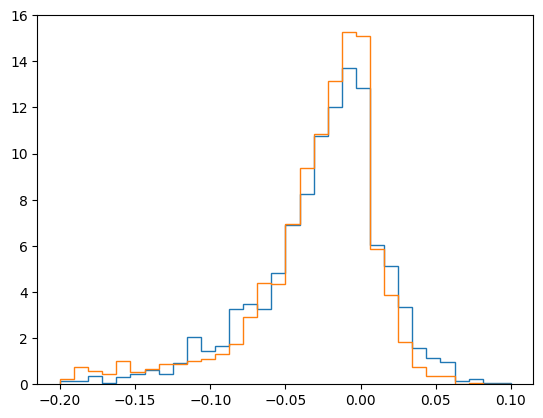

In [233]:
# rng = (0.6, 1.2)
# func = np.array

rng = (-0.2, 0.1)
func = np.log10

plt.hist((func(stars[512]['NFT_Metallicity']/stars[512]['GFM_Metallicity'])), 
         bins=32, range=rng, histtype='step', density=True);

plt.hist((func(stars[1024]['NFT_Metallicity']/stars[1024]['GFM_Metallicity'])), 
         bins=32, range=rng, histtype='step', density=True);

# plt.hist((func(stars[2048]['NFT_Metallicity']/stars[2048]['GFM_Metallicity'])), 
        #  bins=32, range=rng, histtype='step', density=True)

In [18]:
importlib.reload(GFM)
gfm = GFM.GFM(yieldpath, param)

100%|██████████| 1584/1584 [00:24<00:00, 65.90it/s]


In [64]:
nft512 = np.copy(nft[512])
stars512 = np.copy(stars[512])

In [80]:
N = 2048
# nft, stars = {}, {}
nft[N], stars[N] = construct_nft_stars(50, N)
stars[N].sort(order=['BirthTime'])

EdgeZ = np.full_like(nft[N]['TailMetallicity'], -1)
nft[N] = rfn.append_fields(nft[N], 'EdgeZ', EdgeZ, dtypes='float')
assert not np.ma.is_masked(nft[N]['EdgeZ'])
nft[N] = nft[N].filled()

/var/folders/6p/hll0pcr53rx1zjv426_y3zyr0000gn/T/ipykernel_38588/1155165765.py:11: UserWarning: loadtxt: input contained no data: "/Users/abeane/Projects/nft/iso/runs/dev/lvl6-MCnft/output/nft_004.txt"
  nft.append(np.loadtxt(fname, dtype=dtypes))
/var/folders/6p/hll0pcr53rx1zjv426_y3zyr0000gn/T/ipykernel_38588/1155165765.py:11: UserWarning: loadtxt: input contained no data: "/Users/abeane/Projects/nft/iso/runs/dev/lvl6-MCnft/output/nft_015.txt"
  nft.append(np.loadtxt(fname, dtype=dtypes))
/var/folders/6p/hll0pcr53rx1zjv426_y3zyr0000gn/T/ipykernel_38588/1155165765.py:11: UserWarning: loadtxt: input contained no data: "/Users/abeane/Projects/nft/iso/runs/dev/lvl6-MCnft/output/nft_016.txt"
  nft.append(np.loadtxt(fname, dtype=dtypes))
/var/folders/6p/hll0pcr53rx1zjv426_y3zyr0000gn/T/ipykernel_38588/1155165765.py:11: UserWarning: loadtxt: input contained no data: "/Users/abeane/Projects/nft/iso/runs/dev/lvl6-MCnft/output/nft_021.txt"
  nft.append(np.loadtxt(fname, dtype=dtypes))
/var/fol

In [66]:
print('star names', stars[N].dtype.names)
print('nft names', nft[N].dtype.names)

star names ('ParticleIDs', 'BirthTime', 'GFM_Metallicity', 'GFM_InitialMass', 'Masses', 'NFT_Metallicity')
nft names ('TracerID', 'TailID', 'HeadID', 'EjectFrac', 'GFM_EjectZ', 'GFM_EjectZ_fromMetals', 'TailIdx', 'HeadIdx', 'TailMetallicity', 'EdgeZ')


In [81]:
NFT_Metallicity = {}
NFT_Metallicity_fromGFM = {}
for N in [512, 2048]:
    NFT_Metallicity[N] = np.zeros_like(stars[N]['GFM_Metallicity'])
    NFT_Metallicity_fromGFM[N] = np.zeros_like(stars[N]['GFM_Metallicity'])

    NFT_Metallicity[N][0] = 0.0127
    NFT_Metallicity_fromGFM[N][0] = 0.0127
    nft[N]['EdgeZ'] = -1
    nft[N]['EdgeZ'][nft[N]['TailID']==0] = NFT_Metallicity[N][0]

    for i in tqdm(range(1, len(stars[N]))):
        # compute star's metallicity
        star = stars[N][i]

        starID = star['ParticleIDs']
    
        # find all edges that point to this star
        edges = nft[N][nft[N]['HeadID'] == starID]
        if not np.all(edges['EdgeZ'] >= 0.0):
            print(edges[edges['EdgeZ']<0.0])
            assert False

        # compute the metallicity of the star
        z = np.mean(edges['EdgeZ'])
        z_GFM = np.mean(edges['GFM_EjectZ_fromMetals'])
        NFT_Metallicity[N][i] = z
        NFT_Metallicity_fromGFM[N][i] = z_GFM

        # compute the metallicity of the edges
        key = nft[N]['TailID'] == starID
    
        frac = nft[N]['EjectFrac'][key]
        z = np.full_like(frac, z)
        sub_edgeZ = gfm.get_tracer_metallicity(frac, z)

        nft[N]['EdgeZ'][key] = sub_edgeZ

# stars[N]['NFT_Metallicity'] = NFT_Metallicity

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Text(0.5, 1.0, 'stars')

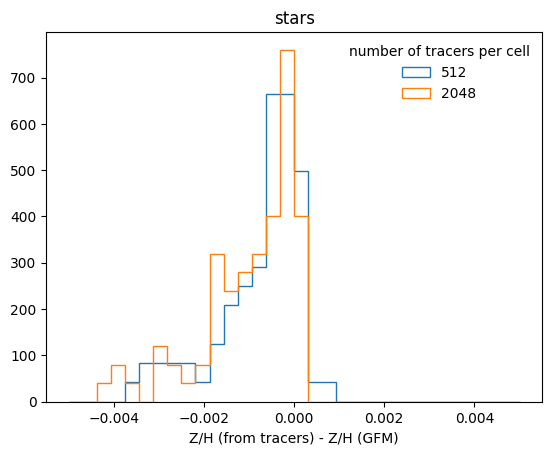

In [88]:
# plt.hist(NFT_Metallicity - stars[N]['GFM_Metallicity'], bins=32, range=(-0.005, 0.005), histtype='step', density=True)
plt.hist(NFT_Metallicity_fromGFM[512] - stars[512]['GFM_Metallicity'], bins=32, range=(-0.005, 0.005), histtype='step', density=True, label='512');
plt.hist(NFT_Metallicity_fromGFM[2048] - stars[2048]['GFM_Metallicity'], bins=32, range=(-0.005, 0.005), histtype='step', density=True, label='2048');
plt.legend(frameon=False, title='number of tracers per cell')
plt.xlabel('Z/H (from tracers) - Z/H (GFM)')
plt.title('stars')

In [38]:
key = nft[N]['TailID'] > 0
print(nft[N]['EdgeZ'][key][2])
print(nft[N]['GFM_EjectZ'][key][2])
print(nft[N]['GFM_EjectZ_fromMetals'][key][2])
print(nft[N]['TracerID'][key][2])
print(nft[N]['HeadID'][key][2])
print(nft[N]['TailID'][key][2])
print('EjectFrac', nft[N]['EjectFrac'][key][2])
TailID = nft[N]['TailID'][key][2]
tailkey = nft[N]['HeadID']==TailID
frac = nft[N]['EjectFrac'][key][2]
z = 0.0127
edgez = gfm.get_tracer_metallicity(frac, z)
print(edgez)

0.21050855607909397
0.31032
0.293375
269925
68890
66955
EjectFrac 0.0255362
0.21050855607909402


In [37]:
print(np.log10(0.0127))
mej, met = gfm.get_total_mass_ejected(0.00429694, 0.000954875, 0.0127)
print(met/mej)

-1.8961962790440432
0.3103195988257105


In [44]:
gfm.get_tracer_metallicity(0.0255, 0.0127)

0.2099526200720748

In [43]:
print(1-0.000291198/0.000304891, 1-(0.0198202*0.000304891 + 0.000291198)/(0.000304891))

0.04491113217510523 0.025090932175105274


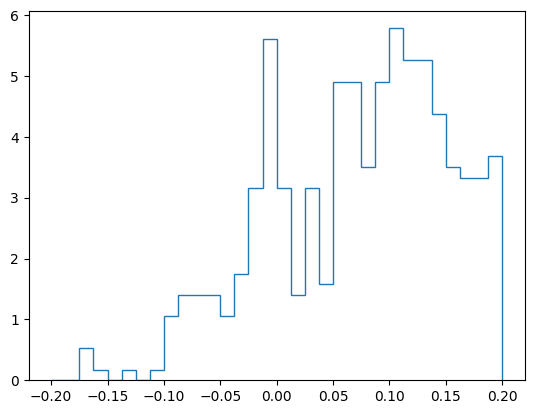

In [49]:
obs = nft[N]['EdgeZ'][key]
exp = nft[N]['GFM_EjectZ_fromMetals'][key]
plt.hist((obs-exp)/exp, bins=32, range=(-0.2, 0.2), histtype='step', density=True);

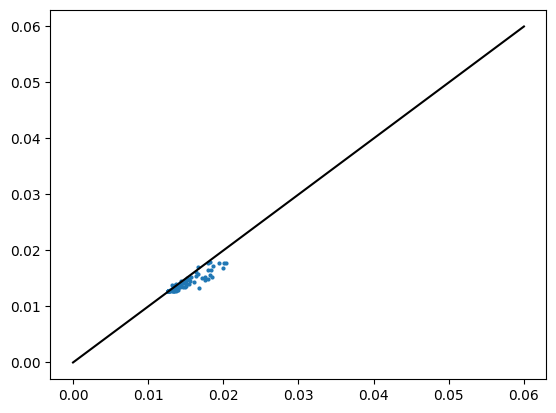

In [53]:
plt.scatter(stars[N]['GFM_Metallicity'], stars[N]['NFT_Metallicity'], s=4)
plt.plot([0, 0.06], [0, 0.06], c='k')

1
[1156]
('ParticleIDs', 'BirthTime', 'GFM_Metallicity', 'GFM_InitialMass', 'Masses', 'NFT_Metallicity')
[(582625, 0.3392334, 0.03872482, 6.89815698e-05, 5.28243327e-05, 0.02313023)]
[0.59729724]
696 67 0.09626436781609195
[735.80341103]


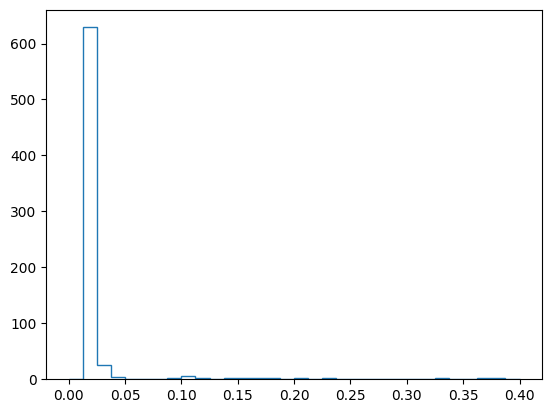

In [40]:
key = np.logical_and(stars[N]['GFM_Metallicity'] > 0.038, NFT_Metallicity < 0.025)
key = np.where(key)[0]
print(len(key))
print(key)
print(stars[N].dtype.names)
print(stars[N][key])
star = stars[N][key]

print(star['NFT_Metallicity']/star['GFM_Metallicity'])
starID = star['ParticleIDs']
num_head = len(np.where(nft[N]['HeadID'] == starID)[0])
num_nonprim = len(np.where(np.logical_and(nft[N]['HeadID'] == starID, nft[N]['TailID']!=0))[0])
print(num_head, num_nonprim, num_nonprim/num_head)

exp_num_head = N * star['GFM_InitialMass'] / 4.8e-5
print(exp_num_head)

tailnft = nft[N][nft[N]['TailID'] == starID]
headnft = nft[N][nft[N]['HeadID'] == starID]

# plt.hist(tailnft['EjectFrac'], bins=32, range=(0, 0.4), histtype='step');
plt.hist(headnft['EdgeZ'], bins=32, range=(0, 0.4), histtype='step');

In [12]:
# k = np.argmax(stars['GFM_Metallicity'])
k = np.where(np.logical_and(stars['GFM_Metallicity'] > 0.016, stars['NFT_Metallicity'] < 0.014))[0]
assert len(k) == 1
k = k[0]

print('GFM_metal=', round(stars['GFM_Metallicity'][k], 4))
print('NFT_metal=', round(stars['NFT_Metallicity'][k], 4))

print('log_error= ', np.log10(stars['NFT_Metallicity'][k]/stars['GFM_Metallicity'][k]))

starID = stars['ParticleIDs'][k]
# print(starID)

subnft = nft[nft['HeadID'] == starID]
print('subnft length:', len(subnft))
print('nonprimitive edges:', len(np.where(subnft['TailID'] != 0)[0]))
print('edgez:', subnft['EdgeZ'][subnft['TailID'] > 0])
print((5*np.sum(subnft['EdgeZ'][subnft['TailID'] > 0]) + 509*0.0127)/512)

GFM_metal= 0.0168
NFT_metal= 0.0135
log_error=  -0.09669443419788017
subnft length: 604
nonprimitive edges: 3
edgez: [0.37072117 0.09901702 0.03041984]
0.017509941765534397


0.16671934559690746


/var/folders/6p/hll0pcr53rx1zjv426_y3zyr0000gn/T/ipykernel_15839/2136607536.py:9: RuntimeWarning: invalid value encountered in divide
  plt.plot(xlist, met/mej, c='k')


(0.0, 0.4)

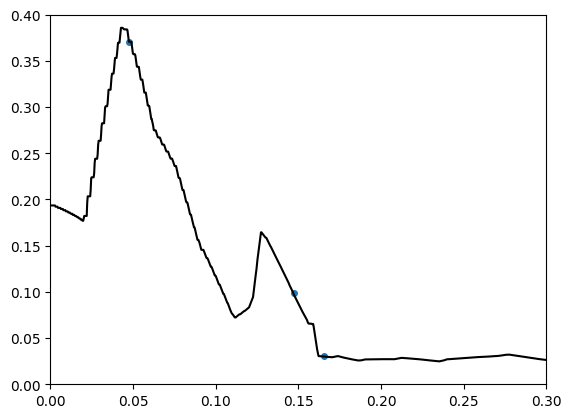

In [13]:
plt.scatter(subnft['EjectFrac'], subnft['EdgeZ'], s=16)

xlist = np.linspace(0, 0.3, 1000)
mej = np.zeros_like(xlist)
met = np.zeros_like(xlist)
for i,x in enumerate(xlist):
    mej[i], met[i] = gfm.get_total_mass_ejected_at_frac(x-0.01*x, x+0.01*x, 0.0127)

plt.plot(xlist, met/mej, c='k')

print(np.mean(subnft['EdgeZ'][subnft['TailID'] != 0]))
plt.xlim(0, 0.3)
plt.ylim(0, 0.4)

  0%|          | 0/1412 [00:00<?, ?it/s]

-0.023215600428152974 1.0157394444532764


/var/folders/6p/hll0pcr53rx1zjv426_y3zyr0000gn/T/ipykernel_23152/2861195227.py:23: RuntimeWarning: invalid value encountered in sqrt
  dist = (num_head - exp_head)/np.sqrt(exp_head)


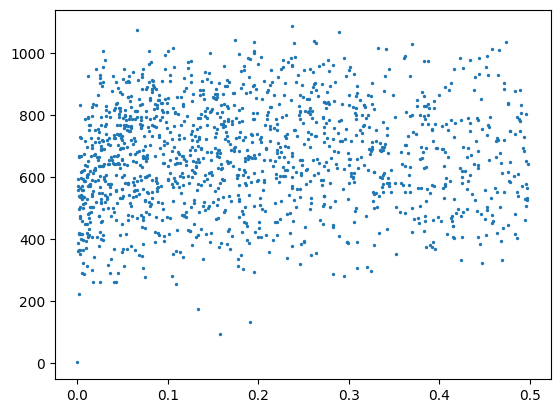

In [192]:
N = 512
redo = True
refmass = 4.8e-5
# for N in [512]:
if redo:
    num_head = []
    num_nonprim = []
    exp_head = []
    for i,ID in enumerate(tqdm(stars[N]['ParticleIDs'])):
        num_head.append(len(np.where(nft[N]['HeadID'] == ID)[0]))
        num_nonprim.append(len(np.where(np.logical_and(nft[N]['HeadID'] == ID, nft[N]['TailID'] != 0))[0]))
        exp_head.append(N * stars[N][i]['GFM_InitialMass']/refmass)

    num_head = np.array(num_head)
    num_nonprim = np.array(num_nonprim)
    exp_head = np.array(exp_head)

# plt.plot(stars[N]['GFM_Metallicity'], num_nonprim/num_head, 'o', ms=2)
plt.scatter(stars[N]['BirthTime'], num_head, s=2)
# mean = np.mean(num_head)
# print(mean)
# plt.hist((num_head-mean)/mean, bins=32, histtype='step', density=True)
dist = (num_head - exp_head)/np.sqrt(exp_head)
# mean, std = np.mean(num_head), np.std(num_head)
mean, std = np.mean(dist[1:]), np.std(dist[1:])
print(mean, std)

In [190]:
num_head[1]

690

In [191]:
stars[N][1]

(514527, 0.13623047, 0.01289107, 6.60186551e-05, 4.85289856e-05, 0.01297145)

In [179]:
sn = arepo.Snapshot(basepath + '/iso/runs/beta0/lvl5-512/output', 100, combineFiles=True)
is_star = sn.part4.GFM_StellarFormationTime > 0
lam = np.mean(sn.part4.GFM_InitialMass[is_star])/sn.parameters.ReferenceGasPartMass * 512
# print(1/np.sqrt(lam))
print(lam)

666.2302848115664


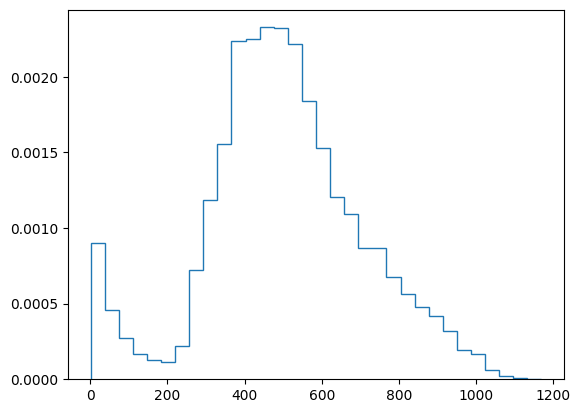

In [178]:
ID, c = np.unique(sn.part6.ParentID, return_counts=True)
gas_c = c[np.isin(ID, sn.part0.ParticleIDs)]
plt.hist(gas_c, bins=32, histtype='step', density=True);

In [96]:
print((0.045 - 0.0127) / (0.175))

0.18457142857142855


5.491935412167106
0.4000350492407716 0.03644783667823396 0.09111160821385146
not ranomd 0.0912209787600301


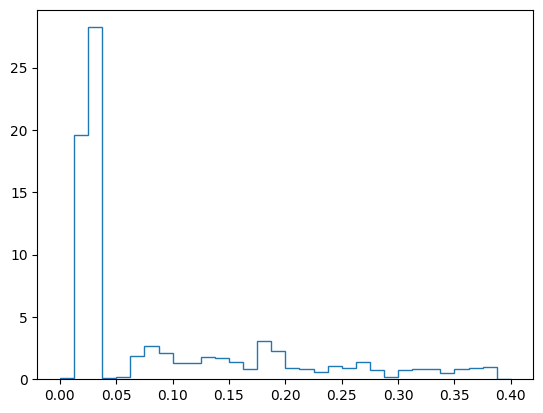

In [118]:
tau = gfm.get_time_of_frac(0.4, 0.0127)
print(tau)
mej, met = gfm.get_total_mass_ejected_at_frac(0.0, 0.4, 0.0127)
print(mej, met, met/mej)
z_true = met/mej

frac = np.linspace(0.0, 0.4, 1000)
df = 0.01 * frac
z = np.full_like(frac, 0.0127)
mej, met = gfm.get_total_mass_ejected_at_frac(frac-df/2., frac+df/2., z)
print('not ranomd', np.mean(met/mej))
# plt.hist((zmean-z_true)/z_true, bins=32, range=(-1, 1), histtype='step', density=True);
plt.hist(met/mej, bins=32, range=(0, 0.4), histtype='step', density=True);



In [284]:
np.random.seed(42)

frac = 0.4 * np.random.rand(10000)
df = 0.01 * frac
z = np.full_like(frac, 0.0127)
mej, met = gfm.get_total_mass_ejected_at_frac(frac-df/2., frac+df/2., z)
# mej = mej.reshape((100, 100))
# met = met.reshape((100, 100))
# zmean = np.mean(met/mej, axis=1)
# zmedian = np.median(met/mej, axis=1)

zmeasured = met/mej
Nlist = []
Nlist = np.arange(10, 50)
zlist_mean = np.zeros_like(Nlist, dtype='float')
for i,N in enumerate(tqdm(Nlist)):
    Nsamp = 1000
    for _ in range(Nsamp):
        frac = 0.4 * np.random.rand(100)
        df = 0.01 * frac
        z = np.full_like(frac, 0.0127)
        mej, met = gfm.get_total_mass_ejected_at_frac(frac-df/2., frac+df/2., z)
        zlist_mean[i] += np.mean(met/mej)
    zlist_mean[i] /= Nsamp
# plt.hist(zmeasured[0,:10], bins=100);
# plt.axvline(z_true, c='k')
    
plt.plot(Nlist, zlist_mean)
# plt.plot(Nlist, zlist_median)
plt.axhline(z_true, c='k')
plt.xlim(0, Nlist[-1])


KeyboardInterrupt: 

/var/folders/6p/hll0pcr53rx1zjv426_y3zyr0000gn/T/ipykernel_23152/4049621981.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  mean[i] = (N/(N-1))*np.mean(sample[:N])


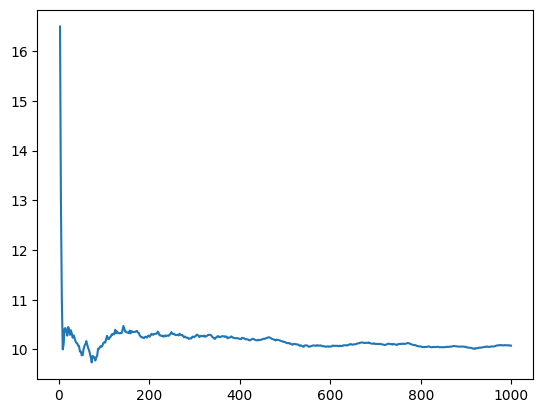

In [145]:
sample = np.random.poisson(10, 1000)

Nlist = np.arange(1, len(sample), 2)
Nlist = np.arange(1, 1000, 2)
mean = np.zeros_like(Nlist, dtype=float)
for i,N in enumerate(Nlist):
    mean[i] = (N/(N-1))*np.mean(sample[:N])

plt.plot(Nlist, mean)

In [134]:
Nlist

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207,
       209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233,
       235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259,
       261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285,
       287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311,
       313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337,
       339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 36